## The Transformer Network for the Traveling Salesman Problem

Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [1]:
###################
# Libs
###################

import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from scipy.optimize import linear_sum_assignment

# visualization 
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
try: 
    import networkx as nx
    from scipy.spatial.distance import pdist, squareform
    from concorde.tsp import TSPSolver # !pip install -e pyconcorde
except:
    print("Fail to import concorde.tsp")
    pass
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


/tmp/ipykernel_1600099/3786564012.py:22: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png2x','pdf')


In [2]:
###################
# Hardware : CPU / GPU(s)
###################

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '1' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)


GPU name: NVIDIA RTX A6000, gpu_id: 1
cuda


In [3]:
###################
# Hyper-parameters
###################

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        
args = DotDict()
args.nb_nodes = 20 # TSP20
args.nb_nodes = 50 # TSP50
#args.nb_nodes = 100 # TSP100
args.bsz = 512 # TSP20 TSP50
args.dim_emb = 128
args.dim_ff = args.dim_emb * 4
args.dim_input_nodes = 2
args.nb_layers_encoder = 6
args.nb_layers_decoder = 6
args.nb_heads = 8
args.nb_epochs = 10000
args.nb_batch_per_epoch = 2500
args.nb_batch_eval = 20
args.gpu_id = gpu_id
args.lr = 1e-4
args.tol = 1e-3
args.batchnorm = True  # if batchnorm=True  than batch norm is used
#args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)


{'nb_nodes': 50, 'bsz': 512, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 6, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 2500, 'nb_batch_eval': 20, 'gpu_id': '1', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


In [4]:
###################
# Network definition
# Notation : 
#            bsz : batch size
#            nb_nodes : number of nodes/cities
#            dim_emb : embedding/hidden dimension
#            nb_heads : nb of attention heads
#            dim_ff : feed-forward dimension
#            nb_layers : number of encoder/decoder layers
###################
def compute_tour_length(x, tour): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    bsz = x.shape[0]
    nb_nodes = x.shape[1]
    arange_vec = torch.arange(bsz, device=x.device)
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)
    previous_cities = first_cities
    L = torch.zeros(bsz, device=x.device)
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L


class Transformer_encoder_net(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes+1, nb_nodes+1) batch of attention scores
    """
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(Transformer_encoder_net, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Transformer_decoder_net(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes+1, nb_nodes+1) batch of attention scores
    """
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(Transformer_decoder_net, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.CRS_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )

        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm3_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm3_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, q, k, v):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        q = q.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)
        k = k.transpose(0,1)
        v = v.transpose(0,1)
        # L layers
        for i in range(self.nb_layers):
            q_rc = q # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            q, score = self.MHA_layers[i](q, q, q) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            q = q_rc + q # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                q = q.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                q = self.norm1_layers[i](q)       # size(h)=(bsz, dim_emb, nb_nodes)
                q = q.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                q = self.norm1_layers[i](q)       # size(h)=(nb_nodes, bsz, dim_emb)

            q_rc = q
            q, score = self.CRS_layers[i](q, k, v)
            q = q_rc + q # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                q = q.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                q = self.norm2_layers[i](q)       # size(h)=(bsz, dim_emb, nb_nodes)
                q = q.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                q = self.norm2_layers[i](q)       # size(h)=(nb_nodes, bsz, dim_emb)
            
            # feedforward
            q_rc = q # residual connection
            q = self.linear2_layers[i](torch.relu(self.linear1_layers[i](q)))
            q = q_rc + q # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                q = q.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                q = self.norm3_layers[i](q)       # size(h)=(bsz, dim_emb, nb_nodes)
                q = q.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                q = self.norm3_layers[i](q) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        q = q.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return q, score
    
    
class TSP_net(nn.Module): 
    
    def __init__(self, dim_input_nodes, dim_emb, dim_ff, 
                 nb_layers_encoder, nb_layers_decoder, nb_heads, batchnorm=True):
        super(TSP_net, self).__init__()
        
        self.dim_emb = dim_emb
        
        # input embedding layer
        self.input_emb = nn.Linear(dim_input_nodes, dim_emb)
        
        # encoder layer
        self.encoder = Transformer_encoder_net(nb_layers_encoder, dim_emb, nb_heads, dim_ff, batchnorm)

        self.decoder = Transformer_decoder_net(nb_layers_decoder, dim_emb, nb_heads, dim_ff, batchnorm)

        self.query_box = nn.Parameter(torch.randn(50, dim_emb))

        self.linear_class = nn.Linear(dim_emb, 50)
        self.linear_box = nn.Linear(dim_emb, 2)
        
    def forward(self, x):

        # input embedding layer
        h = self.input_emb(x) # size(h)=(bsz, nb_nodes, dim_emb)
        
        # encoder layer
        h_encoder, _ = self.encoder(h) # size(h)=(bsz, nb_nodes, dim_emb)

        h_decoder, _ = self.decoder(self.query_box.unsqueeze(0).expand(x.size(0), -1, -1), h_encoder, h_encoder)

        return self.linear_class(h_decoder), self.linear_box(h_decoder)
    


    

model = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, batchnorm=args.batchnorm)

# uncomment these lines if trained with multiple GPUs
print(torch.cuda.device_count())
if torch.cuda.device_count()>1:
    model = nn.DataParallel(model)
    model_baseline = nn.DataParallel(model_baseline)
# uncomment these lines if trained with multiple GPUs

optimizer = torch.optim.Adam( model.parameters() , lr = args.lr ) 

model = model.to(device)

print(args); print('')

# Logs
os.system("mkdir logs")
time_stamp=datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1) 
file.write(time_stamp+'\n\n') 
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n') 
plot_performance_train = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# # Uncomment these lines to re-start training with saved checkpoint


class TSPDataset(Dataset):
    def __init__(self, data_path):
        self.data, self.label = torch.load(data_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.long)
        return data, label


train_data_path = "./train_data_50.pth"
val_data_path = "./val_data_50.pth"

train_dataset = TSPDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

val_dataset = TSPDataset(val_data_path)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

def custom_loss(output_class, output_box, label_class, label_box, matched_idx):

    matched_output_box = label_box.gather(1, matched_idx.unsqueeze(-1).expand(-1, -1, label_box.size(-1)))
    matched_output_class = label_class.gather(1, matched_idx.unsqueeze(-1).expand(-1, -1, label_class.size(-1)))

    loss_class = F.cross_entropy(output_class.transpose(1, 2), matched_output_class.squeeze(-1))

    loss_box = F.mse_loss(output_box, matched_output_box)

    loss = loss_class + 0 * loss_box
    return loss, loss_class, loss_box

###################
# Main training loop 
###################
start_training_time = time.time()

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_loss_class = 0.0
    total_loss_box = 0.0
    for data, label_class in dataloader:
        data = data.to(device)
        label_class = label_class.to(device)

        output_class, output_box = model(data)

        batch_size = data.size(0)
        matched_idx_list = []

        with torch.no_grad():
            for i in range(batch_size):
                cost_matrix = torch.norm(output_box[i, None, :, :] - data[i, :, None, :], dim=2)
                cost_matrix = cost_matrix.cpu().numpy()
                _, matched_idx = linear_sum_assignment(cost_matrix)
                matched_idx_list.append(torch.tensor(matched_idx, device=device))

        matched_idx = torch.stack(matched_idx_list)

        loss, loss_class, loss_box = custom_loss(output_class, output_box, label_class, data, matched_idx)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_class += loss_class.item()
        total_loss_box += loss_box.item()

    return total_loss / len(dataloader), total_loss_class / len(dataloader), total_loss_box / len(dataloader)



for epoch in range(0,args.nb_epochs):
    
    # re-start training with saved checkpoint
    epoch += epoch_ckpt

    ###################
    # Train model for one epoch
    ###################
    start = time.time()

    loss, loss_class, loss_box = train_one_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch}, Loss: {loss}, Loss Class: {loss_class}, Loss Box: {loss_box}')
        
    time_one_epoch = time.time() - start
    time_tot = time.time() - start_training_time + tot_time_ckpt

        
    ###################
    # Evaluate train model and baseline on 10k random TSP instances
    ###################
    def compute_tsp_length(points):
        if points.dim() == 2:
            points = points.unsqueeze(0)
        length = torch.norm(points[:, :-1] - points[:, 1:], dim=-1).sum(dim=-1)
        length += torch.norm(points[:, -1] - points[:, 0], dim=-1)
        return length

    def evaluate(model, val_dataloader):
        total_length = 0.0
        total_samples = 0
        
        model.eval()
        with torch.no_grad():
            for data, _ in val_dataloader:
                data = data.to(device)
                output_class, output_box = model(data)

                for i in range(len(data)):
                    cost_matrix = torch.norm(output_box[i, None, :, :] - data[i, :, None, :], dim=2)
                    _, col_idx = linear_sum_assignment(cost_matrix.cpu().numpy())
                    col_idx = torch.tensor(col_idx).to(device)
                    matched_points = torch.index_select(data[i], 0, col_idx)

                    order_probs = torch.nn.functional.softmax(output_class[i], dim=-1)
                    order_cost_matrix = -order_probs
                    _, order = linear_sum_assignment(order_cost_matrix.cpu().numpy())
                    order = torch.tensor(order).to(device)
                    sorted_points = torch.index_select(matched_points, 0, order)
                    
                    tsp_length = compute_tsp_length(sorted_points).item()
                    total_length += tsp_length
                    
                total_samples += len(data)

        average_length = total_length / total_samples
        return average_length

    average_length = evaluate(model, val_dataloader)
    # For checkpoint
    plot_performance_train.append([ (epoch+1), average_length])
        
    # Compute optimality gap
    if args.nb_nodes==50: gap_train = average_length/5.692- 1.0
    elif args.nb_nodes==100: gap_train = average_length/7.765- 1.0
    else: gap_train = -1.0
    
    # Print and save in txt file
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, Length: {:.3f}, gap_train(%): {:.3f}'.format(
        epoch, time_one_epoch/60, time_tot/86400, average_length, 100*gap_train) 
    print(mystring_min) # Comment if plot display
    file.write(mystring_min+'\n')
#     all_strings.append(mystring_min) # Uncomment if plot display
#     for string in all_strings: 
#         print(string)
    
    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss,
        'plot_performance_train': plot_performance_train,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id)))

       

1
{'nb_nodes': 50, 'bsz': 512, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 6, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 2500, 'nb_batch_eval': 20, 'gpu_id': '1', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}



mkdir: cannot create directory ‘logs’: File exists


Epoch 0, Loss: 3.9125937368392942, Loss Class: 3.9125937368392942, Loss Box: 0.7420880039215088
Epoch: 0, epoch time: 11.959min, tot time: 0.008day, Length: 26.401, gap_train(%): 363.826


KeyboardInterrupt: 

In [ ]:
def generate_tsp_instance(num_nodes):
    points = np.random.rand(num_nodes, 2)
    return points

def solve_tsp_concorde(points):
    solver = TSPSolver.from_data(points[:, 0], points[:, 1], norm="EUC_2D")
    solution = solver.solve()
    tour = np.array(solution.tour)
    return tour

def solve_tsp_model(model, points, label_class):
    with torch.no_grad():
        data = torch.tensor(points, dtype=torch.float32).unsqueeze(0)
        output_class, output_box = model(data)

        print(F.cross_entropy(output_class.view(-1, 50), torch.tensor(label_class, dtype=torch.long).view(-1)))

        output_class = output_class.squeeze(0)
        output_box = output_box.squeeze(0)
        order_probs = torch.nn.functional.softmax(output_class, dim=-1)
        order_cost_matrix = -order_probs
        _, order = linear_sum_assignment(order_cost_matrix.cpu().numpy())
        order = torch.tensor(order)
        
        return order, output_box

def plot_tour(points, tour, title):
    plt.figure()
    plt.plot(points[tour, 0], points[tour, 1], 'o-')
    plt.title(title)
    plt.show()

def main(ckpt_path):
    model = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, batchnorm=args.batchnorm)
    model.load_state_dict(torch.load(ckpt_path)['model'])
    model.eval()

    num_nodes = 50
    points = generate_tsp_instance(num_nodes)
    
    tour_concorde = solve_tsp_concorde(points)
    plot_tour(points, tour_concorde, 'Solution by PyConcorde')
    
    order, output_box = solve_tsp_model(model, points, tour_concorde)
    plot_tour(output_box, order, 'Solution by Model')

Problem Name: 5b5450ed545247ebbe62e96d3ed7269a
Problem Type: TSP
Number of Nodes: 50
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 1
   0 Steps   Best: 0   0.00 seconds
  25 Total Steps.
Best cycle length: 0
Lin-Kernighan Running Time: 0.08
LK Initial Run: 0.0
LK Run 0: 0.0
LK Run from best tour: 0.0
Time to find compression tour: 0.29 (seconds)
Set initial upperbound to 0 (from tour)
Fractional Matching: 0.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 0.00
Loading lp...done in 0.00 seconds
LP has:  50 rows  159 columns  318 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 0.000000
Setting tolerances: next cuts 0.0100 next round 0.0010
CCtsp_init_edgegenerator (50)
 1225 edges
LP has:  50 rows  159 columns  318 nonzeros
Loading lp...done i

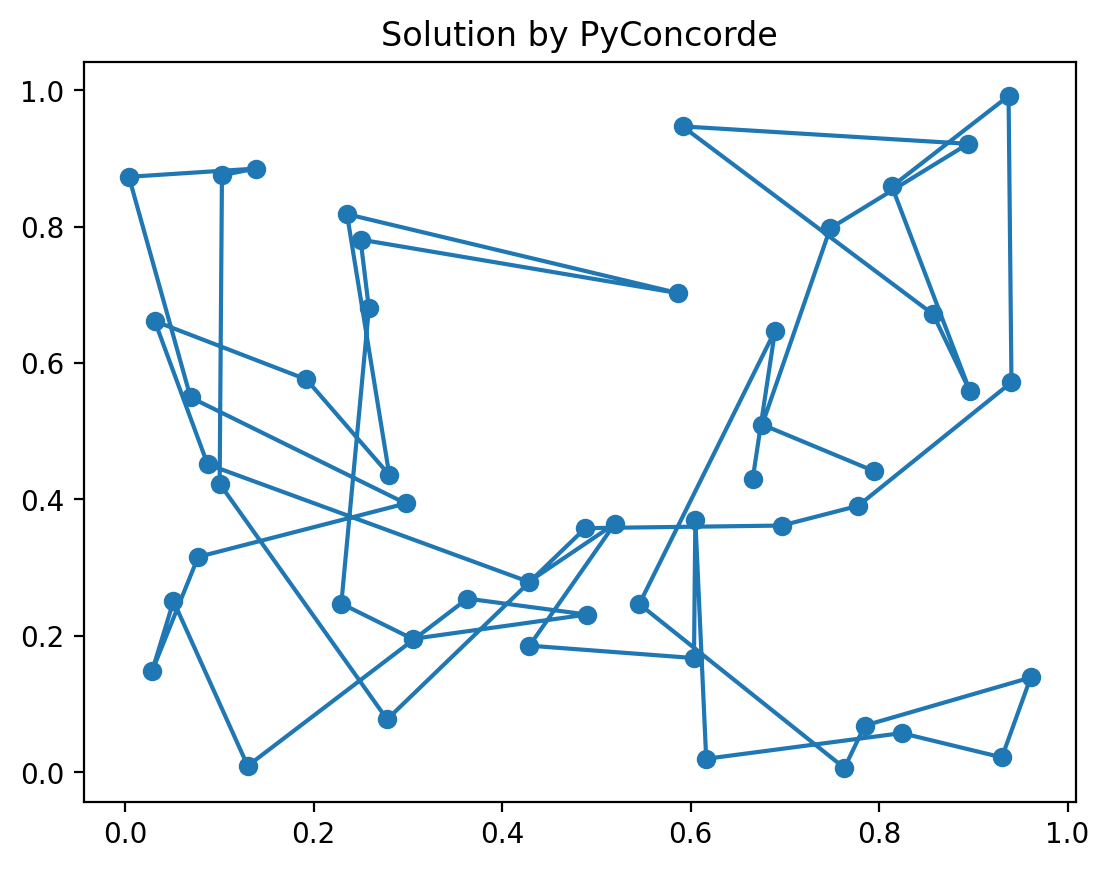

tensor(3.9216)
tensor([[0.4349, 0.4822, 0.4821,  ..., 0.4824, 0.4751, 0.4757],
        [0.4791, 0.5008, 0.4989,  ..., 0.4748, 0.4951, 0.4926],
        [0.3928, 0.5023, 0.5094,  ..., 0.5050, 0.4965, 0.4837],
        ...,
        [0.4351, 0.4858, 0.5028,  ..., 0.5005, 0.5008, 0.4722],
        [0.5094, 0.4689, 0.4931,  ..., 0.5023, 0.5028, 0.4777],
        [0.4659, 0.4779, 0.4898,  ..., 0.5077, 0.4851, 0.4669]])


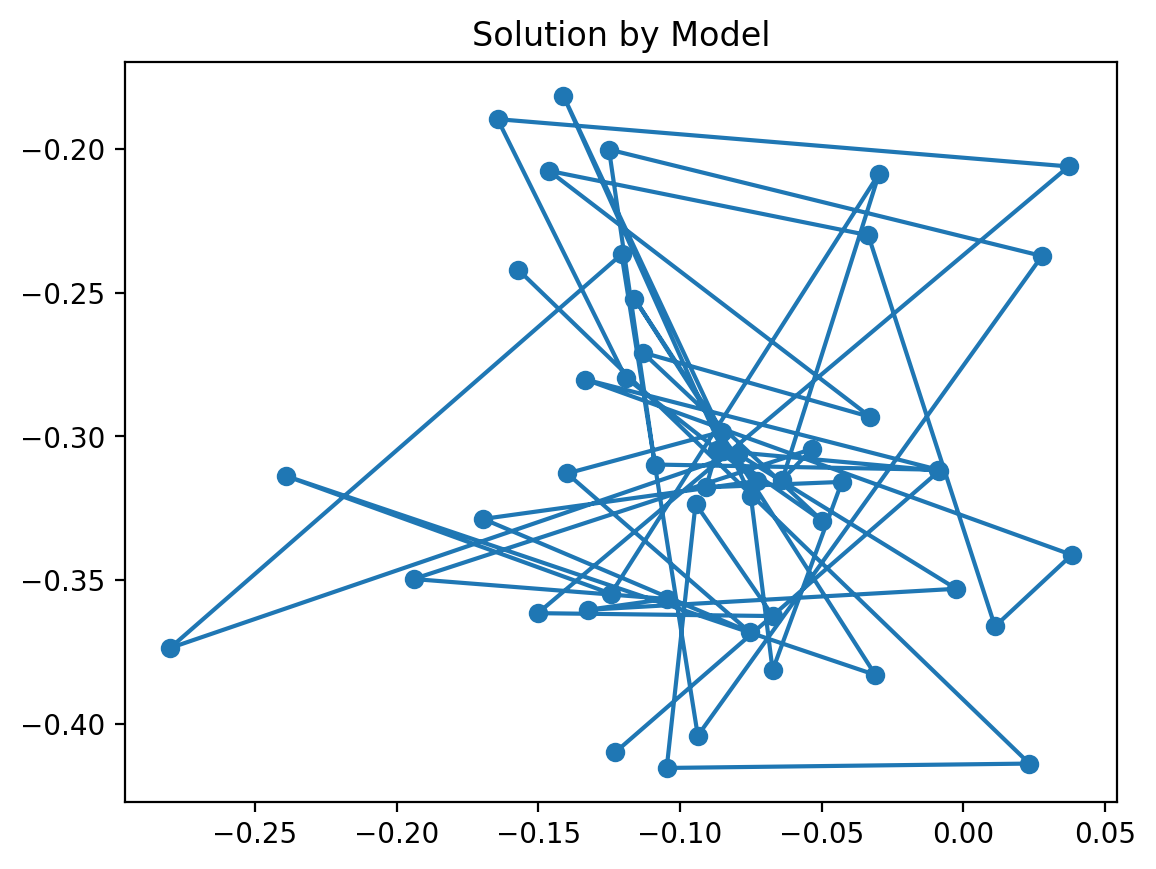

In [ ]:
main("./checkpoint/checkpoint_23-10-22--14-58-01-n50-gpu1.pkl")